# Import Libraries

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import norm

# Binomial-Tree Model

In [138]:
class BinomialTree:
    def __init__(self, S0, K, T, r, sigma, N):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.N = N
        # Generate trees upon initialization
        self.dt, self.u, self.d, self.p = self.initialize_parameters()
        self.stock_tree = self.generate_stock_tree()
        self.option_tree = None

    def initialize_parameters(self):
        if self.N <= 0:
            raise ValueError("Number of time steps N must be greater than zero.")
        if self.T <= 0:
            raise ValueError("Total time T must be greater than zero.")
        if self.sigma <= 0:
            raise ValueError("Volatility sigma must be greater than zero.")
        dt = self.T / self.N
        u = np.exp(self.sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(self.r * dt) - d) / (u - d)
        return dt, u, d, p

    def generate_stock_tree(self):
        stock_tree = np.zeros((self.N + 1, self.N + 1))
        for i in range(self.N + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)
        return stock_tree

    def compute_option_prices(self, option_type='C'):
        self.option_tree = np.zeros_like(self.stock_tree)
        if option_type == 'C':
            self.option_tree[:, self.N] = np.maximum(self.stock_tree[:, self.N] - self.K, 0)
        else:
            self.option_tree[:, self.N] = np.maximum(self.K - self.stock_tree[:, self.N], 0)

        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                self.option_tree[j, i] = np.exp(-self.r * self.dt) * (self.p * self.option_tree[j, i+1] + (1 - self.p) * self.option_tree[j+1, i+1])

    def delta(self):
        if self.N < 1:
            raise ValueError("Delta calculation requires at least one time step (N >= 1).")
        delta = (self.option_tree[0, 1] - self.option_tree[1, 1]) / (self.stock_tree[0, 1] - self.stock_tree[1, 1])
        return delta

    def gamma(self):
        if self.N < 2:
            raise ValueError("Gamma calculation requires at least two time steps (N >= 2).")
        f_uu = self.option_tree[0, 2]
        f_ud = self.option_tree[1, 2]
        f_dd = self.option_tree[2, 2]
        S_uu = self.stock_tree[0, 2]
        S_ud = self.stock_tree[1, 2]
        S_dd = self.stock_tree[2, 2]
        d1 = (f_uu - f_ud) / (S_uu - S_ud)
        d2 = (f_ud - f_dd) / (S_ud - S_dd)
        gamma = (d1 - d2) / ((S_uu - S_dd) / 2)
        return gamma

    def theta(self):
        if self.N < 2:
            raise ValueError("Theta calculation requires at least two time steps (N >= 2).")
        option_price = self.option_tree[0, 0]
        delta = self.delta()
        gamma = self.gamma()
        theta = self.r * option_price - self.r * self.S0 * delta - 0.5 * self.sigma**2 * (self.S0**2) * gamma
        return theta / 365.25  # Convert to daily decay

    def vega(self, option_type='C', delta_sigma=0.01):
        # Store original sigma value to reset later
        original_sigma = self.sigma

        # Increase sigma by delta_sigma and recompute option prices
        self.sigma = original_sigma + delta_sigma
        self.dt, self.u, self.d, self.p = self.initialize_parameters()
        self.stock_tree = self.generate_stock_tree()
        self.compute_option_prices(option_type)
        price_plus = self.option_tree[0, 0]

        # Decrease sigma by delta_sigma and recompute option prices
        self.sigma = original_sigma - delta_sigma
        self.dt, self.u, self.d, self.p = self.initialize_parameters()
        self.stock_tree = self.generate_stock_tree()
        self.compute_option_prices(option_type)
        price_minus = self.option_tree[0, 0]

        # Restore original sigma and recompute parameters and option prices
        self.sigma = original_sigma
        self.dt, self.u, self.d, self.p = self.initialize_parameters()
        self.stock_tree = self.generate_stock_tree()
        self.compute_option_prices(option_type)

        # Calculate Vega using the central difference method
        vega = (price_plus - price_minus) / (2 * delta_sigma)
        return vega

    def visualize_binomial_tree(self):

        G = nx.DiGraph()
        pos = {}

        # Node creation
        for i in range(self.N + 1):
            for j in range(i + 1):
                node = (i, j)
                G.add_node(node,
                          stock=round(self.stock_tree[j, i], 2),
                          option=round(self.option_tree[j, i], 2))
                pos[node] = (i, -j)  # Original positioning

        # Add edges after all nodes exist
        for i in range(self.N):
            for j in range(i + 1):
                G.add_edge((i, j), (i+1, j))     # Down move
                G.add_edge((i, j), (i+1, j+1))   # Up move

        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=False, node_size=300,
               node_color='skyblue', edge_color='gray')

        # Labelling
        for (i, j), (x, y) in pos.items():
            stock_price = G.nodes[(i, j)]['stock']
            option_price = G.nodes[(i, j)]['option']

            plt.text(x, y + 0.20, f"{stock_price}",
                    ha='center', va='bottom',
                    fontsize=10, color='black')
            plt.text(x, y - 0.20, f"{option_price}",
                    ha='center', va='top',
                    fontsize=10, color='red')

        plt.title("Binomial Tree with Stock and Option Prices")
        plt.axis('off')
        plt.show()

***Binomial Model***
Price: 0.171175
Delta: 0.260252
Gamma: 0.302753
Theta: -0.002538
Vega: 1.551355


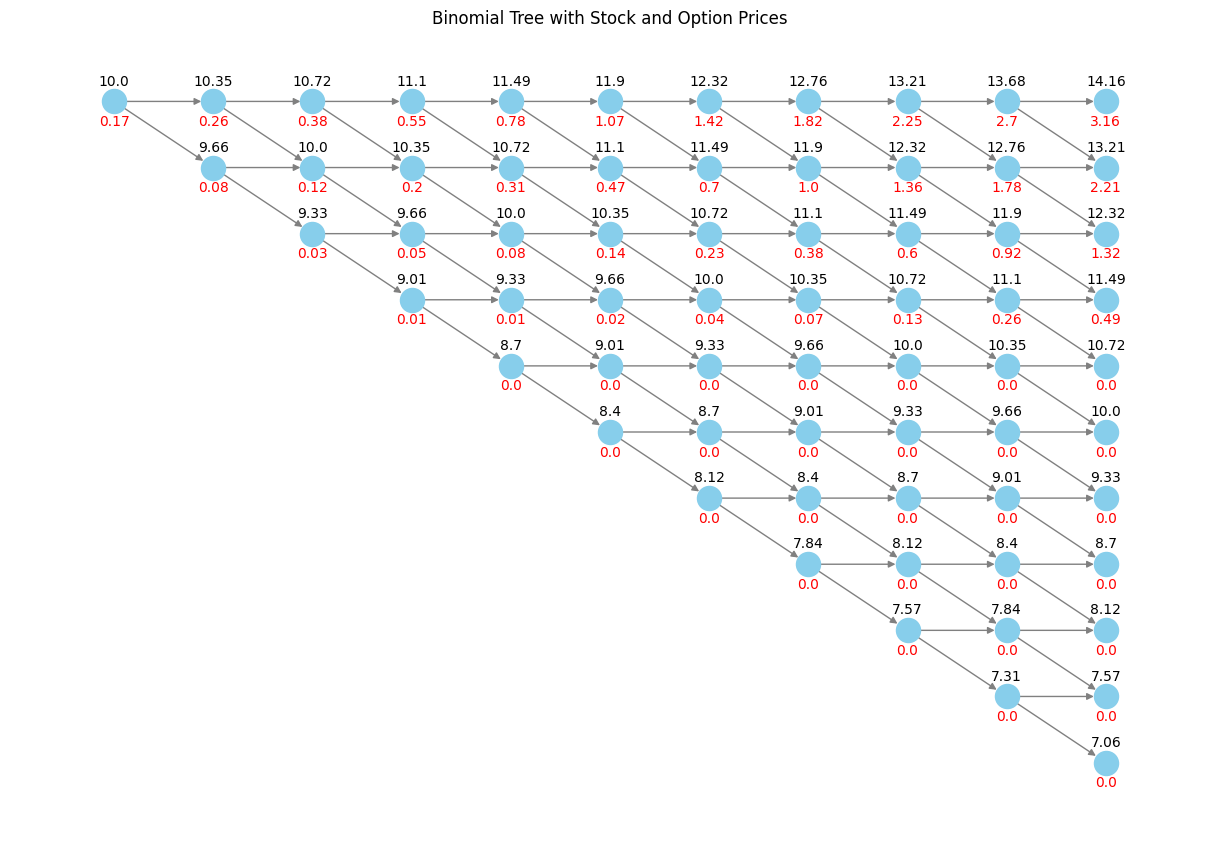

In [139]:
# Example usage of BinomialTree Class

# Current stock price
S0 = 10
# Strike price
K = 11
# Time to maturity in years
T = 0.25
# Risk-free interest rate
r = 0.08
# Volatility
sigma = 0.22
#No of time steps
N = 10
# Option type 'C' for Call option and 'P' for Put option
option_type = 'C'

bt = BinomialTree(S0, K, T, r, sigma, N)
bt.compute_option_prices(option_type)

# Print the results
print("***Binomial Model***",
      f"Price: {bt.option_tree[0, 0]:.6f}",
      f"Delta: {bt.delta():.6f}",
      f"Gamma: {bt.gamma():.6f}",
      f"Theta: {bt.theta():.6f}",
      f"Vega: {bt.vega():.6f}", sep='\n')

# Optionally, visualize the binomial tree with stock and option prices
bt.visualize_binomial_tree()

# Black–Scholes Model

In [140]:
class BlackScholes:
    def __init__(self, S0, K, T, r, sigma):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma

    def price(self, option_type='C'):

        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)

        if option_type == 'C':
            return self.S0 * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        elif option_type == 'P':
            return self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S0 * norm.cdf(-d1)
        else:
            raise ValueError("Option type must be 'C' for call or 'P' for put")

    def delta(self, option_type='C'):

        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        if option_type == 'C':
            return norm.cdf(d1)
        elif option_type == 'P':
            return norm.cdf(d1) - 1
        else:
            raise ValueError("Option type must be 'C' or 'P'")

    def gamma(self):

        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        N_prime_d1 = norm.pdf(d1)
        gamma = N_prime_d1 / (self.S0 * self.sigma * np.sqrt(self.T))
        return gamma

    def theta(self, option_type='C'):

        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        N_prime_d1 = norm.pdf(d1)
        term1 = -self.S0 * N_prime_d1 * self.sigma / (2 * np.sqrt(self.T))

        if option_type == 'C':
            term2 = -self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        elif option_type == 'P':
            term2 = self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-d2)
        else:
            raise ValueError("Option type must be 'C' for call or 'P' for put")

        theta = (term1 + term2) / 365  # Convert to per-day theta
        return theta

    def vega(self):

      d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
      N_prime_d1 = norm.pdf(d1)
      vega = self.S0 * np.sqrt(self.T) * N_prime_d1
      return vega

In [141]:
# Example usage of the BlackScholes class

# Current stock price
S0 = 10
# Strike price
K = 11
# Time to maturity in years
T = 0.25
# Risk-free interest rate
r = 0.08
# Volatility
sigma = 0.22
#No of time steps
N = 10
# Option type 'C' for Call option and 'P' for Put option
option_type = 'C'

bs = BlackScholes(S0, K, T, r, sigma)
print("***BlackScholes***",
    f"Price:{bs.price(option_type):.6f}",
    f"Delta:{bs.delta(option_type):.6f}",
    f"Gamma:{bs.gamma():.6f}",
    f"Theta:{bs.theta(option_type):.6f}",
    f"Vega:{bs.vega():.4f}", sep='\n'
    )

***BlackScholes***
Price:0.167344
Delta:0.264466
Gamma:0.297461
Theta:-0.002515
Vega:1.6360


# Binomial-Tree vs Black-Scholes (Option Price Comparison)

In [142]:
def compare_option_prices(S0, K, T, r, sigma, option_type='C', N_values=[10, 50, 100, 200, 500]):

    # Initialize results dictionary
    results = {
        'Model': ['Black-Scholes Model'] + [f'Binomial Model (n={n})' for n in N_values],
        'Option Price': []
    }

    # Calculate Black-Scholes option price
    bs = BlackScholes(S0, K, T, r, sigma)
    bs_price = bs.price(option_type)
    results['Option Price'].append(bs_price)

    # Calculate Binomial Tree option prices for different N values
    for n in N_values:
        bt = BinomialTree(S0, K, T, r, sigma, n)
        bt.compute_option_prices(option_type)
        bin_price = bt.option_tree[0, 0]  # Root node price
        results['Option Price'].append(bin_price)

    # Create DataFrame and plot
    price_df = pd.DataFrame(results)
    plot_option_prices(price_df)

    return price_df

def plot_option_prices(df):

    # Black-Scholes price for reference line
    bs_price = df.loc[df['Model'] == 'Black-Scholes Model', 'Option Price'].iloc[0]

    # Binomial-Tree prices for each step N
    binomial_df = df[df['Model'] != 'Black-Scholes Model'].copy()
    binomial_df['n'] = binomial_df['Model'].str.extract(r'\(n=(\d+)\)').astype(int)
    binomial_df = binomial_df.sort_values('n')

    # Plot
    plt.figure(figsize=(5,5))
    plt.plot(binomial_df['n'], binomial_df['Option Price'], 'o-', label='Binomial Model')
    plt.axhline(bs_price, color='r', linestyle='--', label='Black-Scholes Model')
    plt.title('Option Price Convergence: Binomial Model vs. Black-Scholes')
    plt.xlabel('Number of Steps (n)')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()

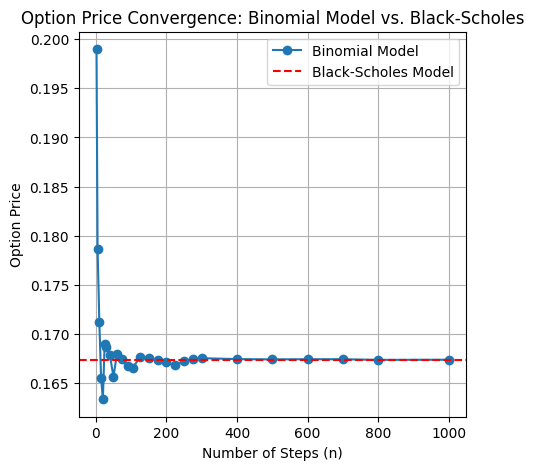

,Model,Option Price
0,Black-Scholes Model,0.167344
1,Binomial Model (n=2),0.198974
2,Binomial Model (n=5),0.178603
3,Binomial Model (n=10),0.171175
4,Binomial Model (n=15),0.165499
5,Binomial Model (n=20),0.163351
6,Binomial Model (n=25),0.168959
7,Binomial Model (n=30),0.168688
8,Binomial Model (n=40),0.167804
9,Binomial Model (n=50),0.165645


In [143]:
# Example for checking option price convergence

# Current stock price
S0 = 10
# Strike price
K = 11
# Time to maturity in years
T = 0.25
# Risk-free interest rate
r = 0.08
# Volatility
sigma = 0.22
#No of time steps
N = [2,5,10,15,20,25,30,40,50,60,75,90,105,125,150,175,200,225,250,275,300,400,500,600,700,800,1000]
# Option type 'C' for Call option and 'P' for Put option
option_type = 'C'

#Option Price Convergence
price_comparison_df = compare_option_prices(S0,K,T,r,sigma,option_type,N)

# Save results
price_comparison_df.to_csv('Option_Price_Comparison.csv', index=False)
price_comparison_df.head(10)

# Binomial-Tree vs Black-Scholes (Greeks Comparison)

In [144]:
def compare_greeks(S0, K, T, r, sigma, option_type='C', N_values=[10, 50, 100, 200, 500]):

    # Initialize results dictionary
    results = {
        'Model': ['Black-Scholes Model'] + [f'Binomial Model (n={n})' for n in N_values],
        'Delta': [],
        'Gamma': [],
        'Vega': [],
        'Theta': []
    }

    # Calculate Black-Scholes Greeks
    bs = BlackScholes(S0, K, T, r, sigma)
    results['Delta'].append(bs.delta(option_type))
    results['Gamma'].append(bs.gamma())
    results['Vega'].append(bs.vega())
    results['Theta'].append(bs.theta(option_type))

    # Calculate Binomial Tree Greeks for different N values
    for n in N_values:
        bt = BinomialTree(S0, K, T, r, sigma, n)
        bt.compute_option_prices(option_type)

        results['Delta'].append(bt.delta())
        results['Gamma'].append(bt.gamma())
        results['Vega'].append(bt.vega(option_type))
        results['Theta'].append(bt.theta())

    # Create DataFrame and plot
    greeks_df = pd.DataFrame(results)
    plot_greeks(greeks_df)

    return greeks_df

def plot_greeks(df, greeks=['Delta', 'Gamma', 'Vega', 'Theta']):
    # Black-Scholes greeks for reference line
    bs_values = df.loc[df['Model'] == 'Black-Scholes Model', greeks].iloc[0]

    # Binomial-Tree greeks for each step N
    binomial_df = df[df['Model'] != 'Black-Scholes Model'].copy()
    binomial_df['n'] = binomial_df['Model'].str.extract(r'\(n=(\d+)\)').astype(int)
    binomial_df = binomial_df.sort_values('n')

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()

    for idx, greek in enumerate(greeks):
        ax = axs[idx]
        ax.plot(binomial_df['n'], binomial_df[greek], 'o-', label='Binomial-Tree')
        ax.axhline(bs_values[greek], color='r', linestyle='--', label='Black-Scholes')
        ax.set_title(f'{greek} Convergence')
        ax.set_xlabel('Number of Steps')
        ax.set_ylabel(greek)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

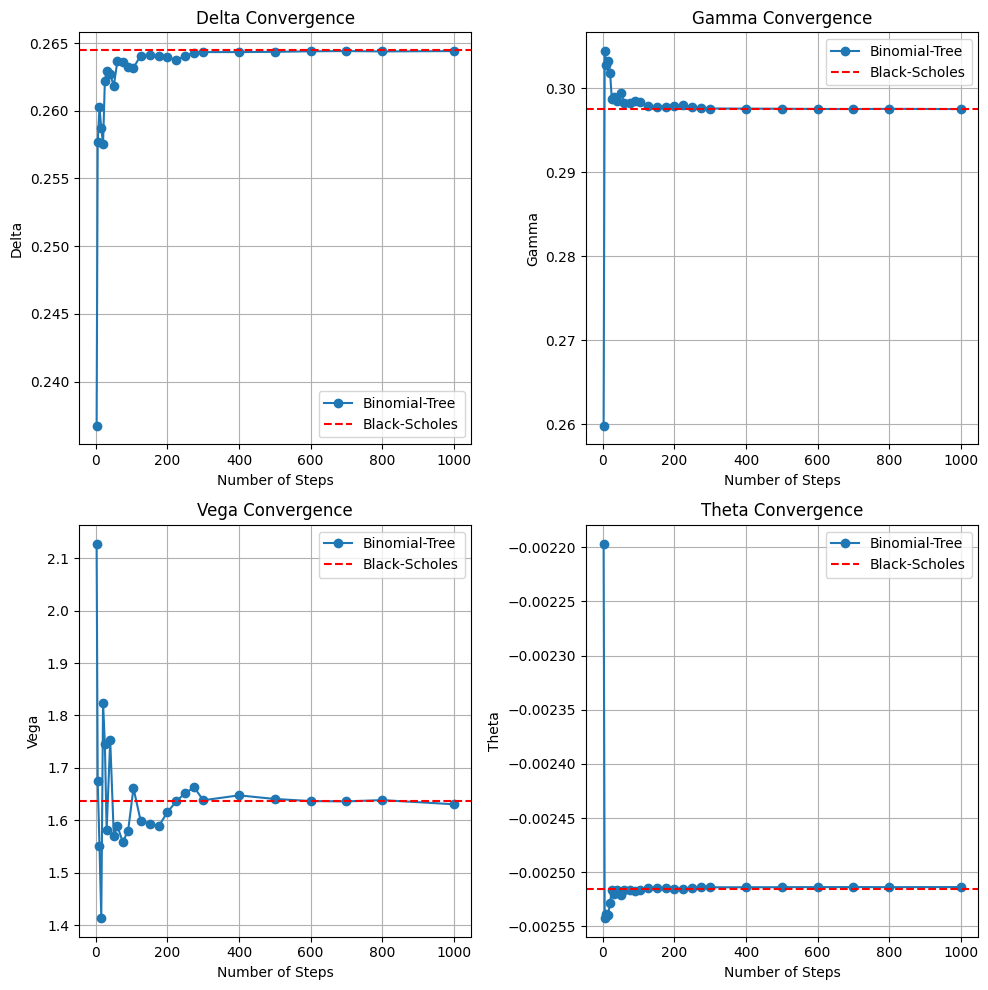

,Model,Delta,Gamma,Vega,Theta
0,Black-Scholes Model,0.264466,0.297461,1.636038,-0.002515
1,Binomial Model (n=2),0.236763,0.259860,2.127787,-0.002197
2,Binomial Model (n=5),0.257686,0.304406,1.674529,-0.002542
3,Binomial Model (n=10),0.260252,0.302753,1.551355,-0.002538
4,Binomial Model (n=15),0.258697,0.303181,1.413884,-0.002539
5,Binomial Model (n=20),0.257564,0.301808,1.824009,-0.002528
6,Binomial Model (n=25),0.262207,0.298669,1.746036,-0.002516
7,Binomial Model (n=30),0.262967,0.298978,1.581486,-0.002520
8,Binomial Model (n=40),0.262681,0.298476,1.752918,-0.002516
9,Binomial Model (n=50),0.261830,0.299448,1.570432,-0.002521


In [145]:
# Example for checking greeks convergence

# Current stock price
S0 = 10
# Strike price
K = 11
# Time to maturity in years
T = 0.25
# Risk-free interest rate
r = 0.08
# Volatility
sigma = 0.22
#No of time steps
N = [2,5,10,15,20,25,30,40,50,60,75,90,105,125,150,175,200,225,250,275,300,400,500,600,700,800,1000]
# Option type 'C' for Call option and 'P' for Put option
option_type = 'C'

#Greeks Convergence
comparison_df = compare_greeks(S0,K,T,r,sigma,option_type,N)

# Save results
comparison_df.to_csv('Greek_Convergence_Comparison.csv', index=False)
comparison_df.head(10)

# Real-world Option Analysis (Call Option)

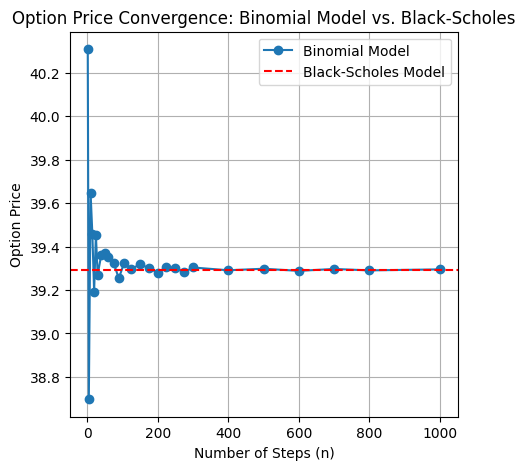

,Model,Option Price
0,Black-Scholes Model,39.291216
1,Binomial Model (n=2),40.308980
2,Binomial Model (n=5),38.697118
3,Binomial Model (n=10),39.647395
4,Binomial Model (n=15),39.457736
5,Binomial Model (n=20),39.192211
6,Binomial Model (n=25),39.454542
7,Binomial Model (n=30),39.271242
8,Binomial Model (n=40),39.359162
9,Binomial Model (n=50),39.371380


In [146]:
# Reliance In-the-Money Call Option

# Current stock price
S0 = 1221.25
# Strike price
K = 1200
# Time to maturity in years
T = 29/365.25
# Risk-free interest rate
r = 0.1
# Volatility
sigma = 0.15
#No of time steps
N = [2,5,10,15,20,25,30,40,50,60,75,90,105,125,150,175,200,225,250,275,300,400,500,600,700,800,1000]
# Option type 'C' for Call option and 'P' for Put option
option_type = 'C'

#Option Price Convergence
price_comparison_df = compare_option_prices(S0,K,T,r,sigma,option_type,N)

# Save results
price_comparison_df.to_csv('Option_Price_Comparison.csv', index=False)
price_comparison_df.head(10)

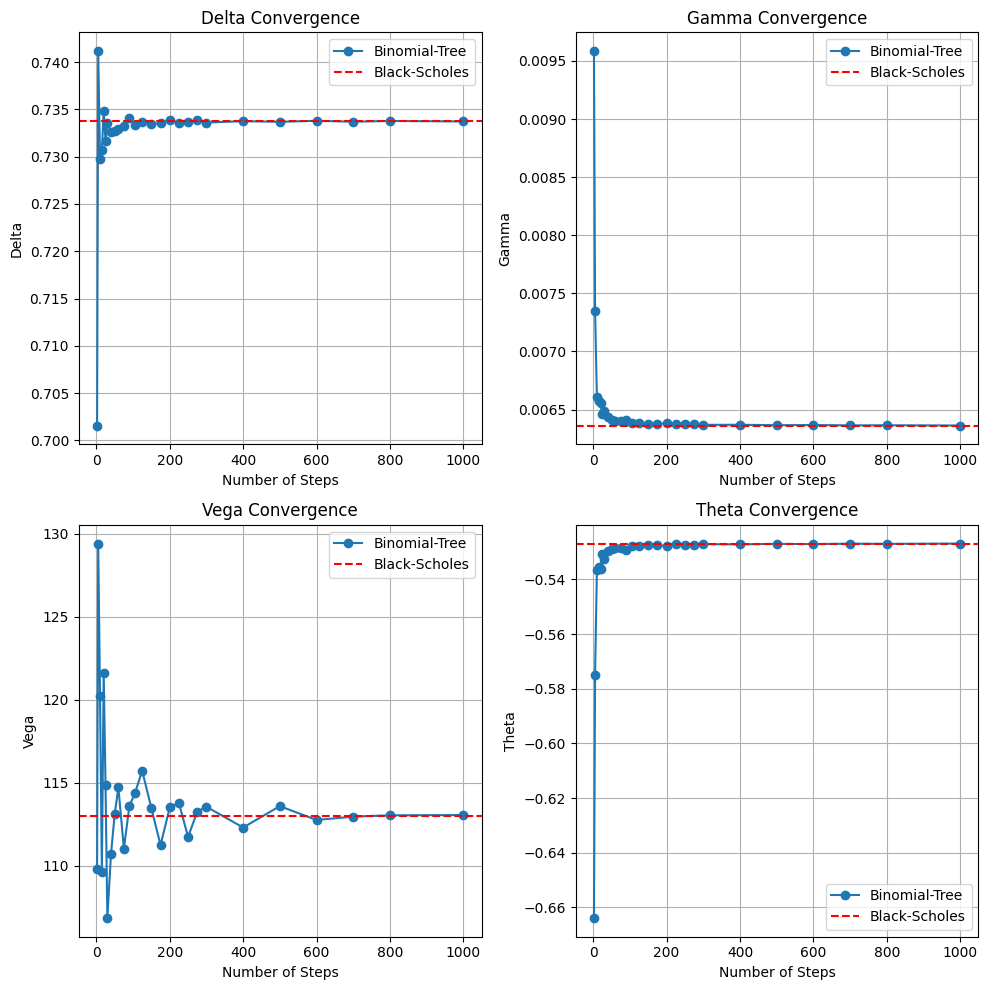

,Model,Delta,Gamma,Vega,Theta
0,Black-Scholes Model,0.733780,0.006360,112.976678,-0.527131
1,Binomial Model (n=2),0.701574,0.009585,109.802426,-0.663859
2,Binomial Model (n=5),0.741173,0.007351,129.402242,-0.574896
3,Binomial Model (n=10),0.729800,0.006606,120.244211,-0.536609
4,Binomial Model (n=15),0.730680,0.006573,109.621883,-0.535476
5,Binomial Model (n=20),0.734830,0.006557,121.593409,-0.536201
6,Binomial Model (n=25),0.731642,0.006458,114.848759,-0.530509
7,Binomial Model (n=30),0.733522,0.006488,106.846199,-0.532561
8,Binomial Model (n=40),0.732664,0.006434,110.722656,-0.529763
9,Binomial Model (n=50),0.732685,0.006410,113.102726,-0.528685


In [147]:
#Greeks Convergence
comparison_df = compare_greeks(S0,K,T,r,sigma,option_type,N)

# Save results
comparison_df.to_csv('Greek_Convergence_Comparison.csv', index=False)
comparison_df.head(10)

# Real-world Option Analysis (Put Option)

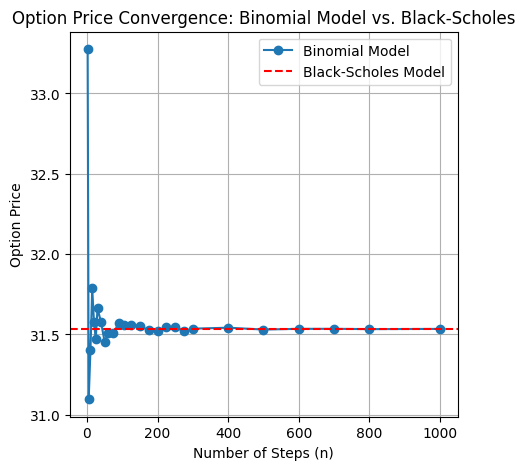

,Model,Option Price
0,Black-Scholes Model,31.531972
1,Binomial Model (n=2),33.275535
2,Binomial Model (n=5),31.096448
3,Binomial Model (n=10),31.405246
4,Binomial Model (n=15),31.786612
5,Binomial Model (n=20),31.575203
6,Binomial Model (n=25),31.471816
7,Binomial Model (n=30),31.661745
8,Binomial Model (n=40),31.575610
9,Binomial Model (n=50),31.455378


In [148]:
# Reliance In-the-Money Put Option

# Current stock price
S0 = 1221.25
# Strike price
K = 1250
# Time to maturity in years
T = 29/365.25
# Risk-free interest rate
r = 0.1
# Volatility
sigma = 0.15
#No of time steps
N = [2,5,10,15,20,25,30,40,50,60,75,90,105,125,150,175,200,225,250,275,300,400,500,600,700,800,1000]
# Option type 'C' for Call option and 'P' for Put option
option_type = 'P'

#Option Price Convergence
price_comparison_df = compare_option_prices(S0,K,T,r,sigma,option_type,N)

# Save results
price_comparison_df.to_csv('Option_Price_Comparison.csv', index=False)
price_comparison_df.head(10)

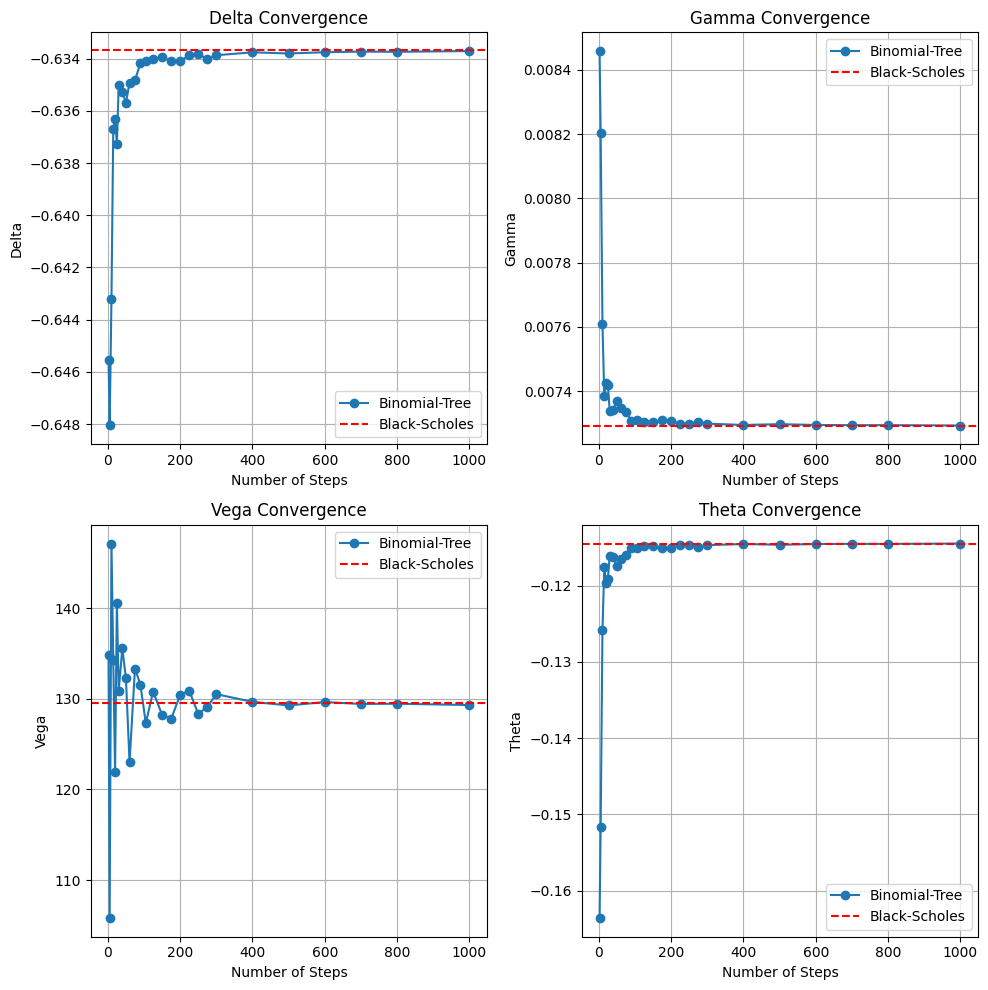

,Model,Delta,Gamma,Vega,Theta
0,Black-Scholes Model,-0.633651,0.007291,129.505583,-0.114506
1,Binomial Model (n=2),-0.645534,0.008458,134.818976,-0.163605
2,Binomial Model (n=5),-0.648057,0.008204,105.804879,-0.151660
3,Binomial Model (n=10),-0.643199,0.007609,147.163142,-0.125870
4,Binomial Model (n=15),-0.636698,0.007384,134.287632,-0.117625
5,Binomial Model (n=20),-0.636310,0.007425,121.897798,-0.119695
6,Binomial Model (n=25),-0.637266,0.007418,140.602356,-0.119096
7,Binomial Model (n=30),-0.635023,0.007339,130.896880,-0.116137
8,Binomial Model (n=40),-0.635266,0.007343,135.595400,-0.116248
9,Binomial Model (n=50),-0.635695,0.007371,132.296532,-0.117429


In [149]:
#Greeks Convergence
comparison_df = compare_greeks(S0,K,T,r,sigma,option_type,N)

# Save results
comparison_df.to_csv('Greek_Convergence_Comparison.csv', index=False)
comparison_df.head(10)